# Estimate SEIR parameters from data for different countries

In [1]:
%run ./Load-Data.ipynb

In [2]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 8, 15

In [3]:
%run ./SEIR.ipynb
def predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values):
    if(S_E_I_R_values is not None):
        init_vals = S_E_I_R_values
    else:
        init_vals = N-1, 1, 0, 0
    params = alpha, beta, gamma,gammaT 
   
    t = np.arange(nSteps)
#     print('t value is ::: ', t)
    results = population_seir_model(init_vals, params, t, N)
    return results

In [4]:
def computeGamma(infected, removed, axs):    
    return computeGammaT(infected, removed, axs).mean()

In [5]:
def computeGammaT(infected, removed, axs):    
    dR_dt= np.diff(removed)
    infected[infected == 0] = 0.0001 # to prevent divide by zero
    gammaT = dR_dt / infected[1:]
    return gammaT

In [6]:
def computeLoss(yhat, infected, removed):
    offsetOfyHat = 0
    offsetOfinfected = 0
    if(len(infected)>len(yhat[2, :])):
        offsetOfinfected = len(infected)-len(yhat[2, :])
    else:
        offsetOfyHat = len(yhat[2, :])-len(infected)
    loss= infected[offsetOfinfected:] - yhat[2,offsetOfyHat:]
    l1 = (loss*loss).sum()
    
    loss= (removed[offsetOfinfected:] - yhat[3,offsetOfyHat:])
    l2 = (loss*loss).sum()
    
    weightForRecovered = 0.9
    return weightForRecovered * l1 + (1 - weightForRecovered) * l2

In [7]:
def estimateMultiStepSierParams(infected, removed, N, axs, stepSize):
    S_E_I_R_values = N-1, 1, 0, 0
    startIndex=0
    cumulativeAlphaHistory = []
    cumulativeBetaHistory = []
    cumulativeGammaHistory = []
    cumulativeLossHistory = []
    cumulativePredInfected = []
    cumulativePredRemoved = []
    cumulativeParams = []
    cumulativeMinLossHistory = []
    
    for index in range(len(infected)):
        if(infected[index]!=0):
            break
    infected = infected[index : ]
    removed = removed[index : ]
    if(stepSize == -1):
        stepSize = len(infected)
    while(startIndex < len(infected)):
        if(startIndex+(stepSize) > len(infected)):
            endIndex = len(infected)
        else:
            endIndex = (startIndex + (stepSize))
        if(endIndex - startIndex < 2):
            break
        infectedDf=infected[startIndex : endIndex]
        removedDf = removed[startIndex : endIndex]
        S_E_I_R_values, params, alphaHistory, betaHistory, gammaHistory, lossHistory, predInfected, predRemoved, minLoss = estimateSingleStepSierParams(S_E_I_R_values, infectedDf, removedDf, N, axs)
        cumulativeAlphaHistory.extend(alphaHistory)
        cumulativeBetaHistory.extend(betaHistory)
        cumulativeGammaHistory.extend(gammaHistory)
        cumulativeLossHistory.extend(lossHistory)
        cumulativePredInfected.extend(predInfected)
        cumulativePredRemoved.extend(predRemoved)
        cumulativeMinLossHistory.append(minLoss)
        cumulativeParams.append(params)
        startIndex = endIndex
        
    axs[0].plot(cumulativePredInfected, label = 'Pred-Infected')
    axs[0].set_title('pred-infected & infected')
    axs[0].plot(infected, label = 'Infected')
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xticks(np.arange(0, (len(infected)+1), 10.0))
    axs[0].legend(loc="upper right")
    axs[1].plot(cumulativePredRemoved, label='Pred-Removed')
    axs[1].set_title('pred-removed & removed')
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].plot(removed, label = 'Removed')
    axs[1].legend(loc="upper right")
    axs[1].set_xticks(np.arange(0, (len(removed)+1), 10.0))
    axs[2].tick_params(axis='x', rotation=90)
    axs[2].plot(cumulativeMinLossHistory, label = 'cumulativeMinLossHistory')
    axs[2].legend(loc="upper right")
    
    
    return cumulativeParams, np.sum(cumulativeMinLossHistory)

In [8]:
def estimateSingleStepSierParams(S_E_I_R_values, infected, removed, N, axs):
    minLoss = -1
    minParams=[]
    lossHistory=[]
    alphaHistory=[]
    betaHistory=[]
    gammaHistory=[]
    minYhat = None
   
    alphaSpace = np.arange(0.001,1,0.05)
    betaSpace = np.arange(0.001,1,0.05)
    gammaSpace = np.arange(0,1,0.001)
    
    nSteps = len(infected)
#     gamma = computeGamma(infected, removed, axs)
    gamma = None
    gammaT = computeGammaT(infected, removed, axs)
    for alpha in alphaSpace:
        for beta in betaSpace:
#             for gamma in gammaSpace:
            yhat = (predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values))
            loss = computeLoss(yhat, infected, removed)
            if(loss < minLoss) or (minLoss == -1):
                minLoss = loss
                if(gamma != None):
                    minParams = [alpha, beta, gamma]
                else:
                    minParams = [alpha, beta, gammaT]
                minYhat = yhat
            lossHistory.append(loss)
            alphaHistory.append(alpha)
            betaHistory.append(beta)
            if(gamma != None):
                gammaHistory.append(gamma)
            else:
                gammaHistory.append(gammaT)
    S_E_I_R_values = int(minYhat[0, -1]), int(minYhat[1, -1]),int(minYhat[2, -1]),int(minYhat[3, -1])
    return S_E_I_R_values, minParams, alphaHistory, betaHistory, gammaHistory, lossHistory, minYhat[2,0:], minYhat[3,0:], minLoss



## Run it for countries

In [9]:
from pandas import *
cumulativeLossDf = DataFrame({'Country': [], 'Accuracy_Score': [], 'Step_Size': []})

def computeParamsWithStepSize(stepSize):
    countries = list(["India", "Pakistan", "Italy", "Spain", "France", "Iran", "China", "Germany", "United Kingdom"])
#     countries = list(["India",  "Pakistan"])
    global cumulativeLossDf
    pyplot.figure(1)
    paramsResultDf = DataFrame({'Country': [], 'Params': []})
    
    for country in countries:
        fig, axs = pyplot.subplots(1,3)
        fig.set_size_inches(30, 5)
        fig.suptitle(country)
        N = int(populationDf [populationDf['Country']==country]['Population'])
        confirmedTSDf = confirmedDf.loc[confirmedDf["Country/Region"] == country].sum().T[4:]
        recoveredTSDf = recoveredDf.loc[recoveredDf["Country/Region"] == country].sum().T[4:]
        deathsTSDf = deathsDf.loc[deathsDf["Country/Region"] == country].sum().T[4:]
        params, cumulativeLoss = estimateMultiStepSierParams(confirmedTSDf, (recoveredTSDf+deathsTSDf), N, axs, stepSize)
        paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params}, ignore_index=True)
        cumulativeLossDf = cumulativeLossDf.append({'Country': country , 'Accuracy_Score': cumulativeLoss, 'Step_Size': stepSize}, ignore_index=True)
        

    fig, axs = pyplot.subplots(1,3)
    fig.set_size_inches(18.5, 5)    
    N = int(populationDf [populationDf['Country']=='United States']['Population'])
    params_us, cumulativeLoss = estimateMultiStepSierParams(total_infected_us_timeseries, total_removed_us_timeseries, N, axs, stepSize)
    country = "The United States"
    fig.suptitle(country)
    paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params_us}, ignore_index=True)
    cumulativeLossDf = cumulativeLossDf.append({'Country': country , 'Accuracy_Score': cumulativeLoss, 'Step_Size': stepSize}, ignore_index=True)
    pandas.set_option('display.max_colwidth', -1)
    display(paramsResultDf)
   


,Country,Params
0,India,"[[0.801, 0.201, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017857142857142856, 0.016129032258064516, 0.0, 0.012195121951219513, 0.0, 0.07964601769911504, 0.0, 0.014084507042253521, 0.0, 0.010309278350515464, 0.02459016393442623, 0.006060606060606061, 0.017676767676767676, 0.006012024048096192, 0.024253731343283583, 0.0076103500761035, 0.013755158184319119, 0.03156708004509583, 0.015197568389057751, 0.013671875, 0.009592326139088728, 0.01717967072297781, 0.024024024024024024, 0.022414471097129376, 0.00038955979742890534, 0.01654769630110318, 0.0036231884057971015, 0.03830054416073671, 0.011297307475051779, 0.01910074374577417, 0.02408921933085502, 0.022900763358778626, 0.028060620412029363, 0.016730038022813688, 0.012245288433942408, 0.01854270044398015]]]"
1,Pakistan,"[[0.751, 0.30100000000000005, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.05263157894736842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.028634361233480177, 0.001996007984031936, 0.0, -0.007731958762886598, 0.001142857142857143, 0.01440329218106996, 0.0037629350893697085, 0.0008326394671107411, 0.0029133284777858705, 0.0046822742474916385, 0.0012523481527864746, 0.0314502038439138, 0.0025799793601651187, 0.008970727101038715, 0.01569599339116068, 0.0026061057334326137, 0.0021291696238466998, 0.027241051631295535, 0.014338821030270845, 0.04312267657992565, 0.009852216748768473, 0.02428157718868345, 0.033226837060702875, 0.010975853123129115, 0.05181644359464627, 0.012554585152838428, 0.04899777282850779]]]"
2,Italy,"[[0.901, 0.251, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.03225806451612903, 0.012903225806451613, 0.013100436681222707, 0.009316770186335404, 0.008830022075055188, 0.0717557251908397, 0.00563063063063063, 0.0070921985815602835, 0.024793388429752067, 0.0412573673870334, 0.015187849720223821, 0.04661702816445452, 0.046397096941420427, 0.034081104400345126, 0.017338092809790925, 0.022508474576271188, 0.021696467509812474, 0.016553355010345848, 0.041486117798106244, 0.0, 0.047168742921857305, 0.03318050763340738, 0.02978138764294662, 0.027269478198713365, 0.0170443725004761, 0.043653571528575026, 0.020519069087364446, 0.013334467578316071, 0.04526111463660458, 0.02710609083837803, 0.009401348413033616, 0.02956227593384989, 0.02310918721264754, 0.021231185397510826, 0.017433929108187474, 0.02512111774374946, 0.014351667024946514, 0.023609431977904244, 0.018394585601935874, 0.016685658473058765, 0.019012165703476164, 0.018743688818046018, 0.015397329738750883, 0.010422806092378323, 0.012508770473869646, 0.015923472924933253, 0.018942491142000546, 0.01802598415328701, 0.017312995927549688, 0.017718409940172455, 0.013481450215204364, 0.01122144487073397, 0.01413642853626114]]]"
3,Spain,"[[0.7010000000000001, 0.30100000000000005, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006060606060606061, 0.0045045045045045045, 0.003861003861003861, 0.005, 0.066, 0.010401188707280832, 0.012115563839701771, 0.004129793510324484, 0.07465963987703118, 0.0004391743522178305, 0.016819571865443424, 0.060397433891409794, 0.01205437291613234, 0.006638503319251659, 0.05864828055839292, 0.010280373831775701, 0.012971107276067472, 0.034002939735423815, 0.03424765508000315, 0.029442436040044494, 0.015340391621129327, 0.043023693117713424, 0.04871251136019388, 0.04094417332918008, 0.04739877356624416, 0.051505427732641496, 0.040506803145674695, 0.033926053936058936, 0.03364156667326918, 0.041404944390019016, 0.045125596751885065, 0.03875871441874512, 0.03531006277344493, 0.03460036765264421, 0.022366928845802086, 0.024481830606867594, 0.03751180677371475, 0.03132056754252, 0.026138381151554594, 0.0243272

<Figure size 432x288 with 0 Axes>

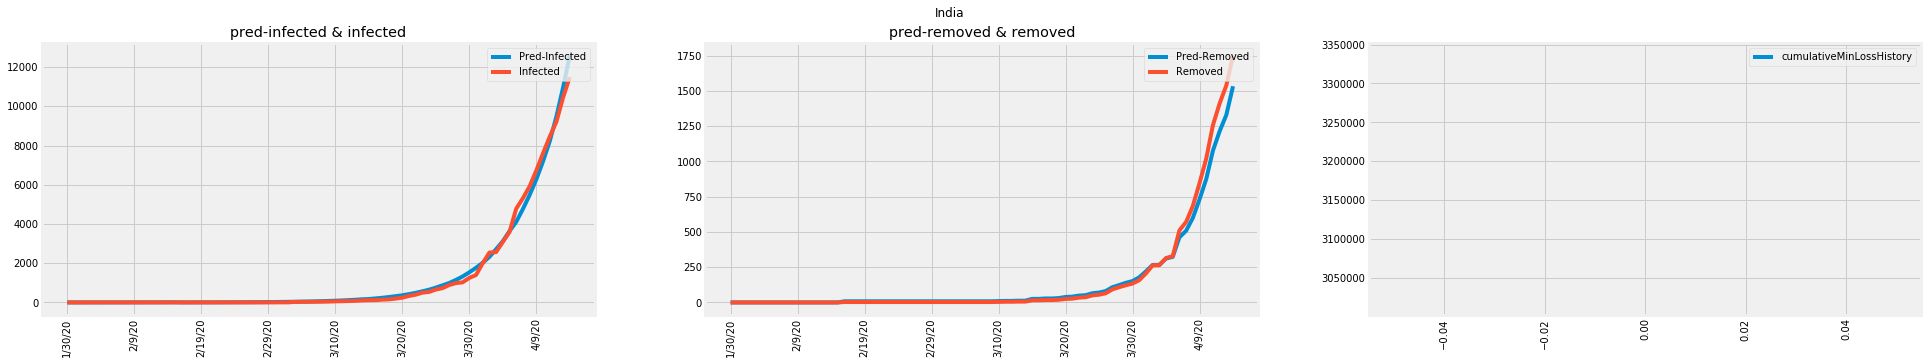

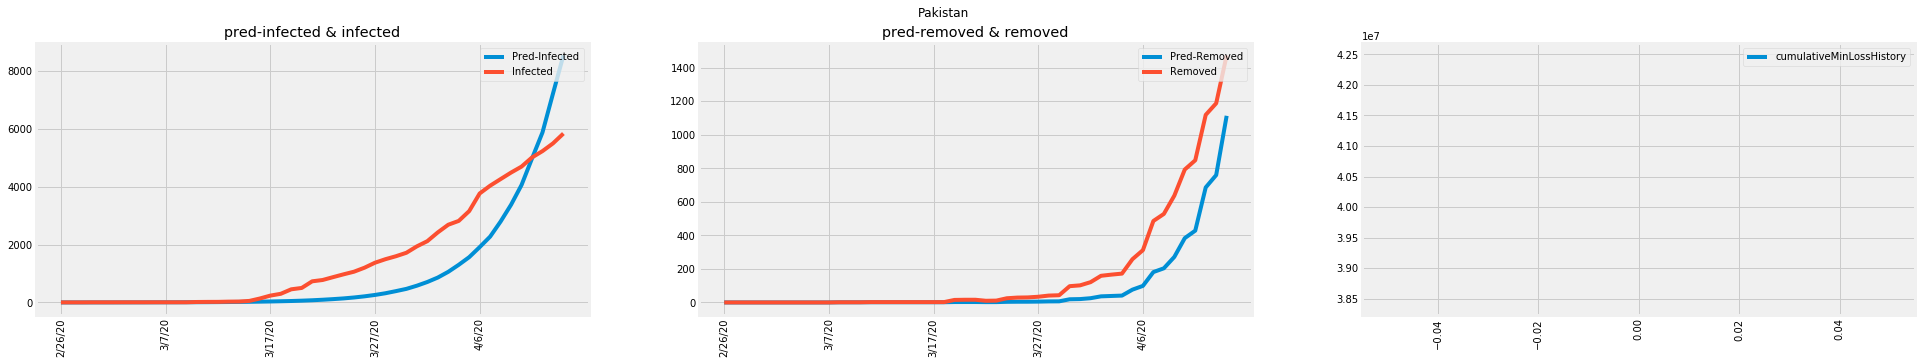

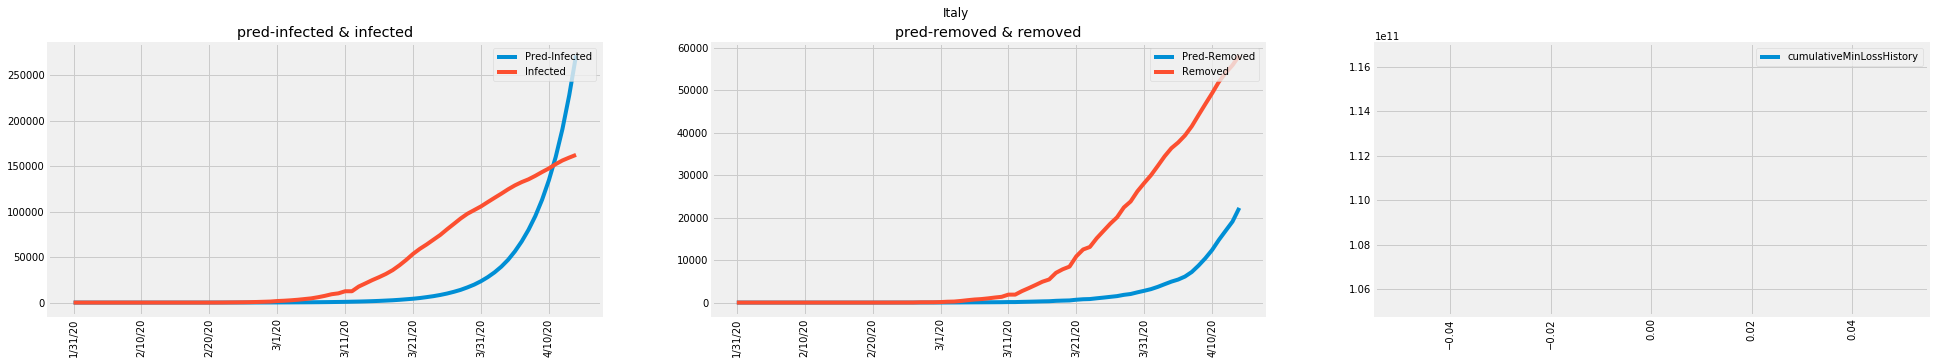

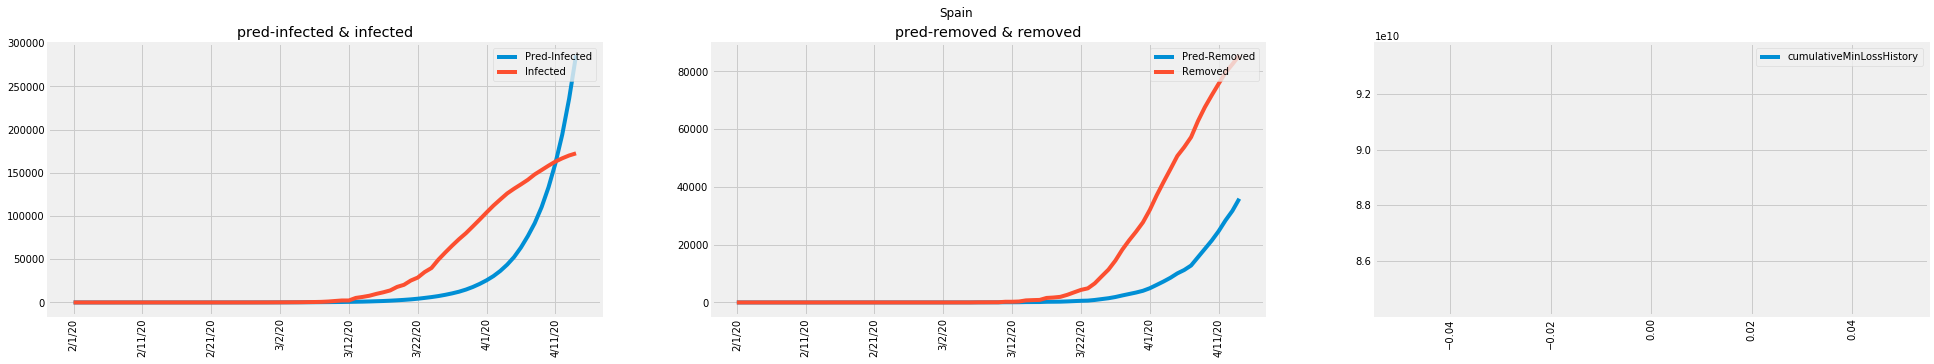

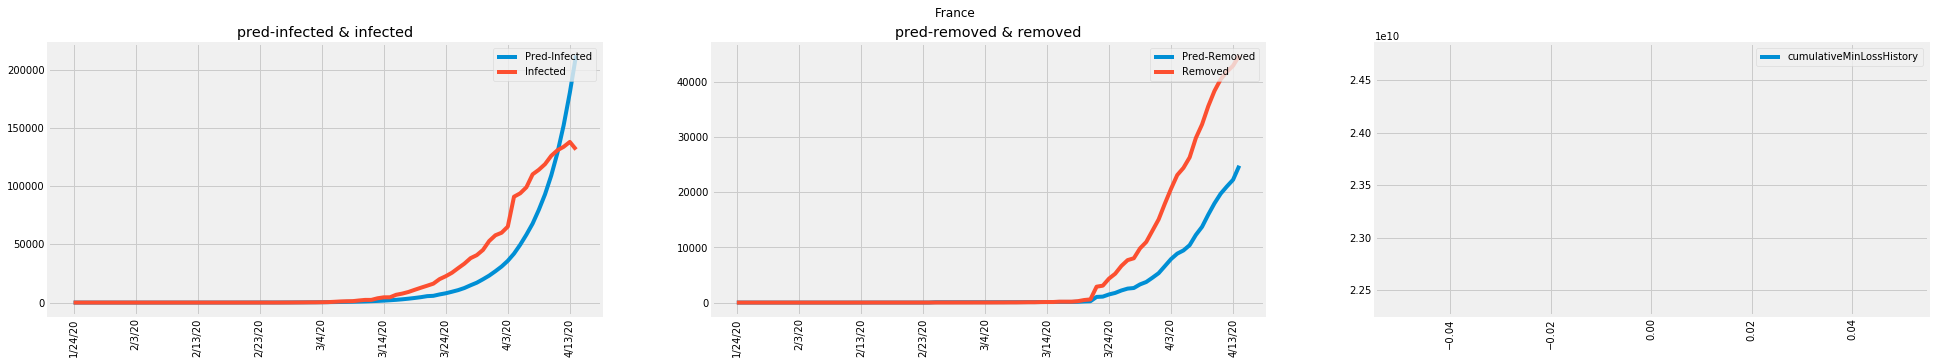

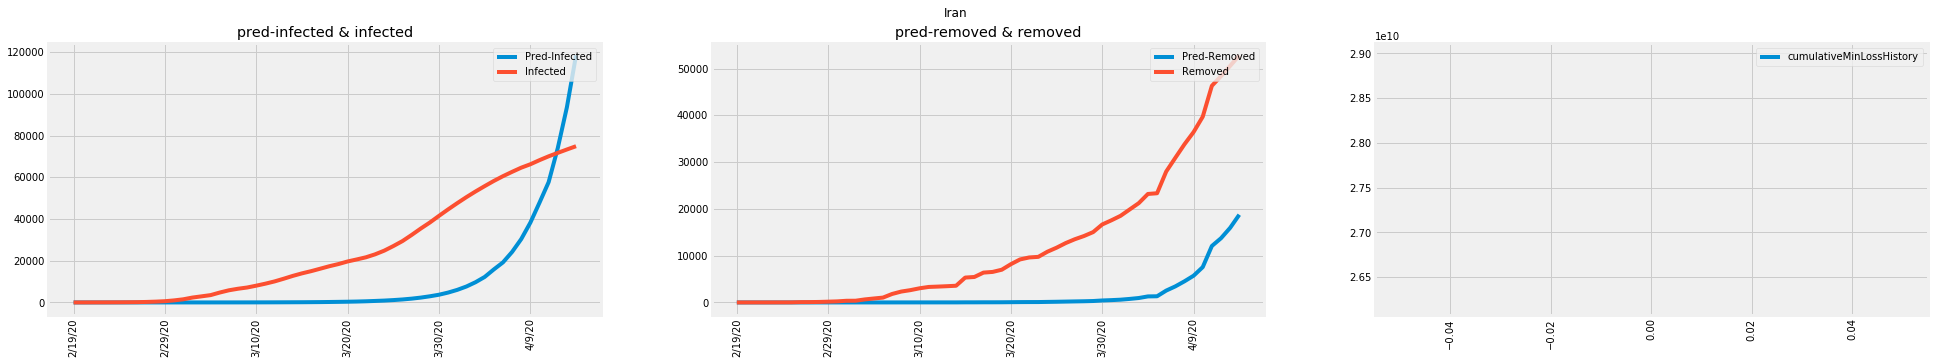

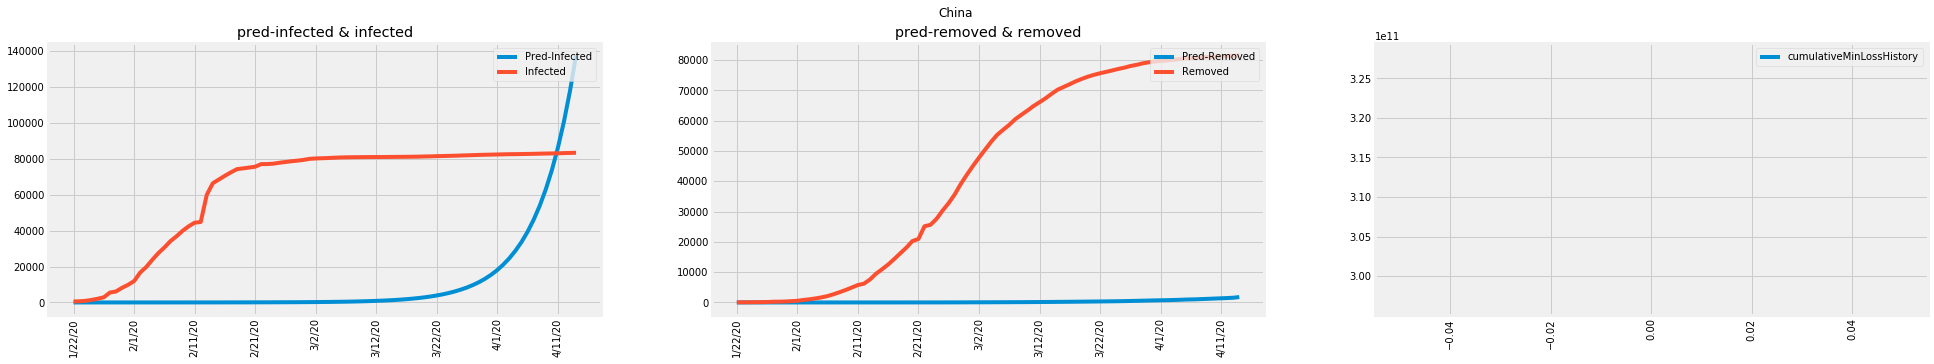

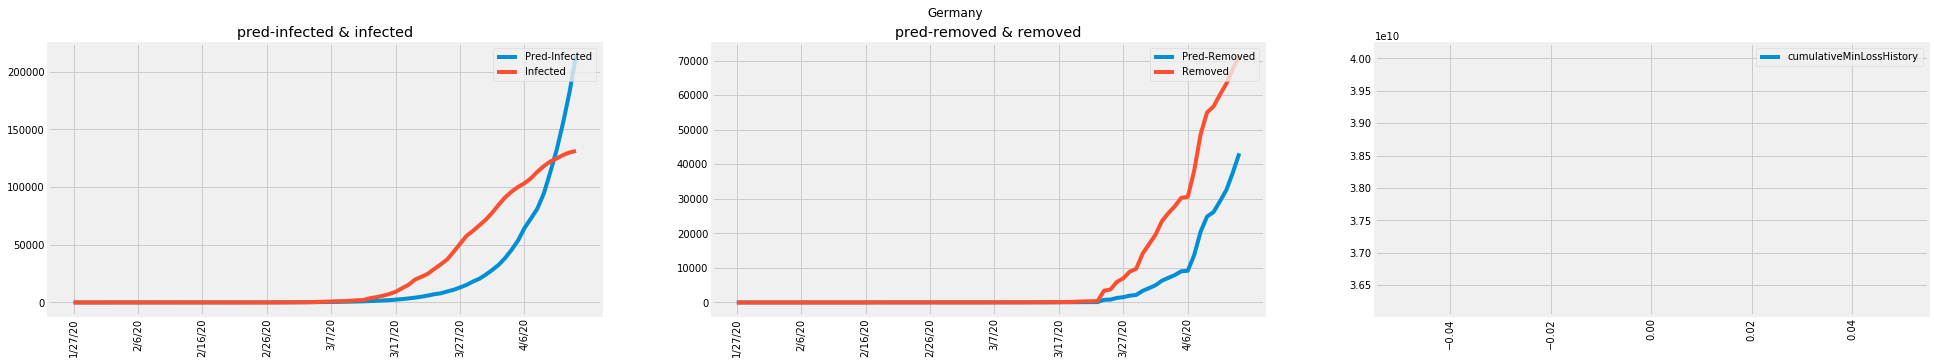

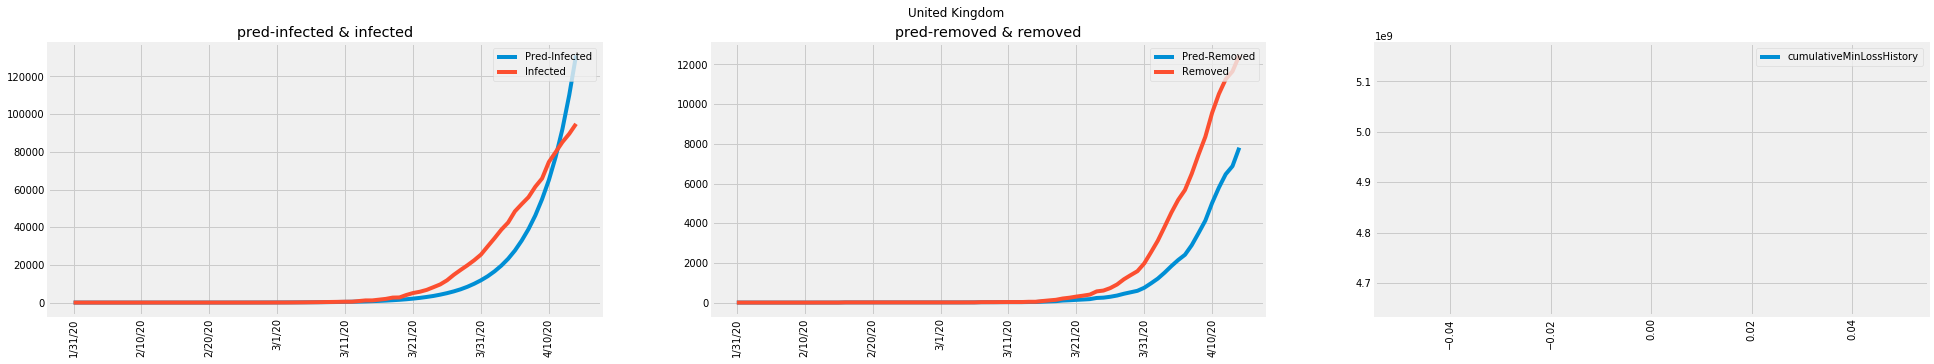

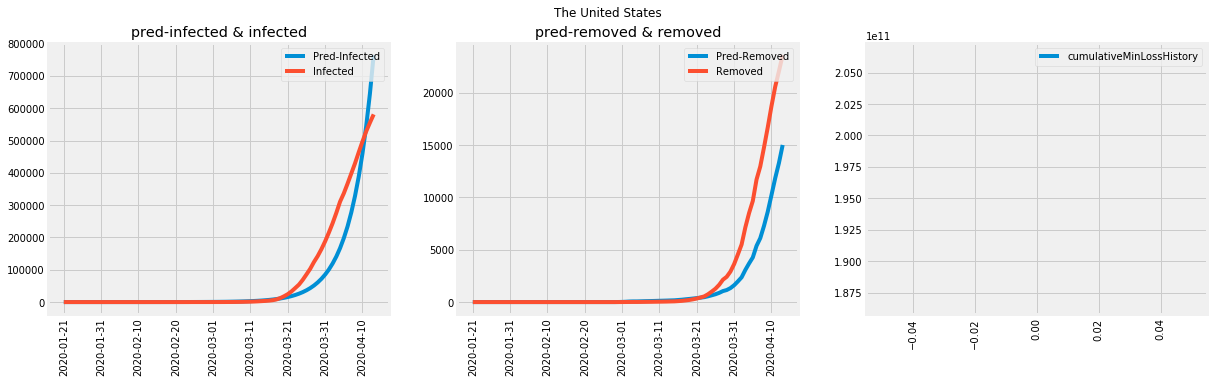

In [10]:
computeParamsWithStepSize(-1)


,Country,Params
0,India,"[[0.9510000000000001, 0.501, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.30100000000000005, 0.451, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.251, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.30100000000000005, 0.251, [0.0, 0.0, 0.0, 0.0, 0.017857142857142856, 0.016129032258064516]], [0.751, 0.15100000000000002, [0.012195121951219513, 0.0, 0.07964601769911504, 0.0, 0.014084507042253521, 0.0]], [0.9510000000000001, 0.451, [0.02459016393442623, 0.006060606060606061, 0.017676767676767676, 0.006012024048096192, 0.024253731343283583, 0.0076103500761035]], [0.201, 0.551, [0.03156708004509583, 0.015197568389057751, 0.013671875, 0.009592326139088728, 0.01717967072297781, 0.024024024024024024]], [0.30100000000000005, 0.251, [0.00038955979742890534, 0.01654769630110318, 0.0036231884057971015, 0.03830054416073671, 0.011297307475051779, 0.01910074374577417]], [0.451, 0.15100000000000002, [0.022900763358778626, 0.028060620412029363, 0.016730038022813688, 0.012245288433942408, 0.01854270044398015]]]"
1,Pakistan,"[[0.9510000000000001, 0.801, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.101, 0.9510000000000001, [0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0]], [0.501, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.30100000000000005, [0.028634361233480177, 0.001996007984031936, 0.0, -0.007731958762886598, 0.001142857142857143, 0.01440329218106996]], [0.6010000000000001, 0.101, [0.0008326394671107411, 0.0029133284777858705, 0.0046822742474916385, 0.0012523481527864746, 0.0314502038439138, 0.0025799793601651187]], [0.8510000000000001, 0.201, [0.01569599339116068, 0.0026061057334326137, 0.0021291696238466998, 0.027241051631295535, 0.014338821030270845, 0.04312267657992565]], [0.401, 0.101, [0.02428157718868345, 0.033226837060702875, 0.010975853123129115, 0.05181644359464627, 0.012554585152838428, 0.04899777282850779]]]"
2,Italy,"[[0.9510000000000001, 0.30100000000000005, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.101, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.9510000000000001, [0.03225806451612903, 0.012903225806451613, 0.013100436681222707, 0.009316770186335404, 0.008830022075055188, 0.0717557251908397]], [0.9510000000000001, 0.9510000000000001, [0.0070921985815602835, 0.024793388429752067, 0.0412573673870334, 0.015187849720223821, 0.04661702816445452, 0.046397096941420427]], [0.9510000000000001, 0.9510000000000001, [0.017338092809790925, 0.022508474576271188, 0.021696467509812474, 0.016553355010345848, 0.041486117798106244, 0.0]], [0.9510000000000001, 0.501, [0.03318050763340738, 0.02978138764294662, 0.027269478198713365, 0.0170443725004761, 0.043653571528575026, 0.020519069087364446]], [0.551, 0.101, [0.04526111463660458, 0.02710609083837803, 0.009401348413033616, 0.02956227593384989, 0.02310918721264754, 0.021231185397510826]], [0.651, 0.101, [0.02512111774374946, 0.014351667024946514, 0.023609431977904244, 0.018394585601935874, 0.016685658473058765, 0.019012165703476164]], [0.30100000000000005, 0.051000000000000004, [0.015397329738750883, 0.010422806092378323, 0.012508770473869646, 0.015923472924933253, 0.018942491142000546, 0.01802598415328701]], [0.35100000000000003, 0.051000000000000004, [0.017718409940172455, 0.013481450215204364, 0.01122144487073397, 0.01413642853626114]]]"
3,Spain,"[[0.9510000000000001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.201, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.9510000000000001, [0.0, 0.0, 0.006060606060606061, 0.0045045045045045045, 0.003861003861003861, 0.005]], [0.901, 0.901, [0.010401188707280832, 0.012115563839701771, 0.004129793510324484, 0.07465963987703118, 0.0004391743522178305, 0.016819571865443424]], [0.9510000000000001, 0.30100000000

<Figure size 432x288 with 0 Axes>

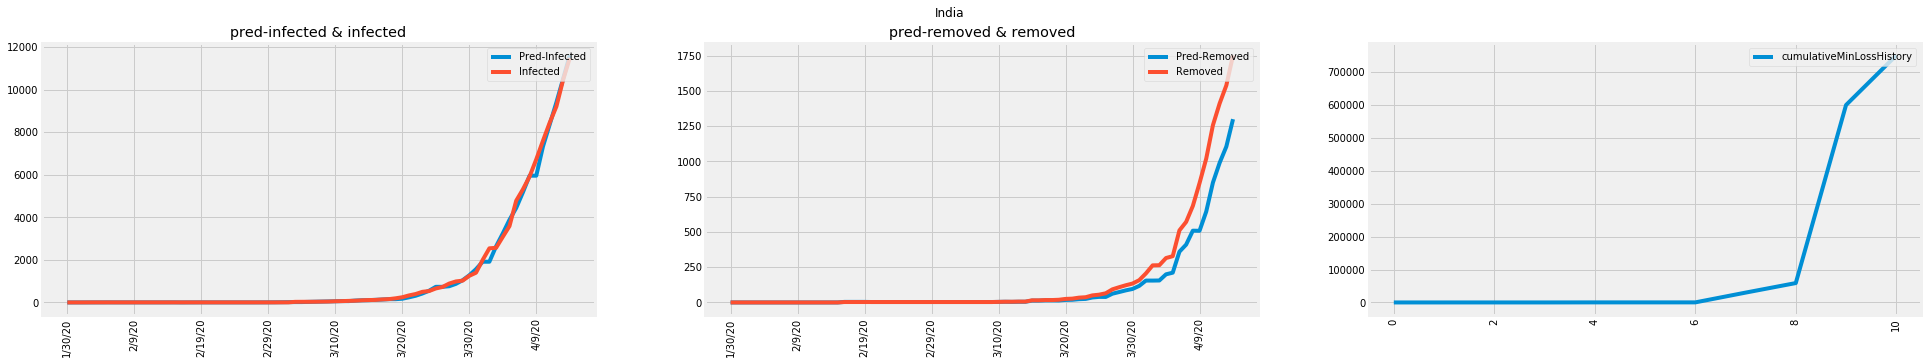

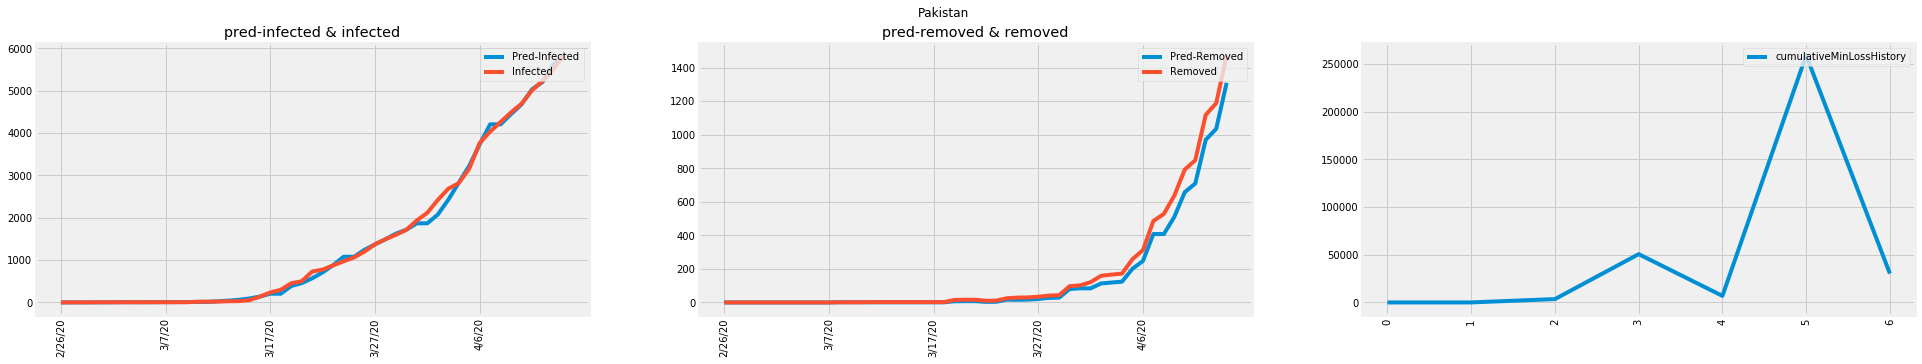

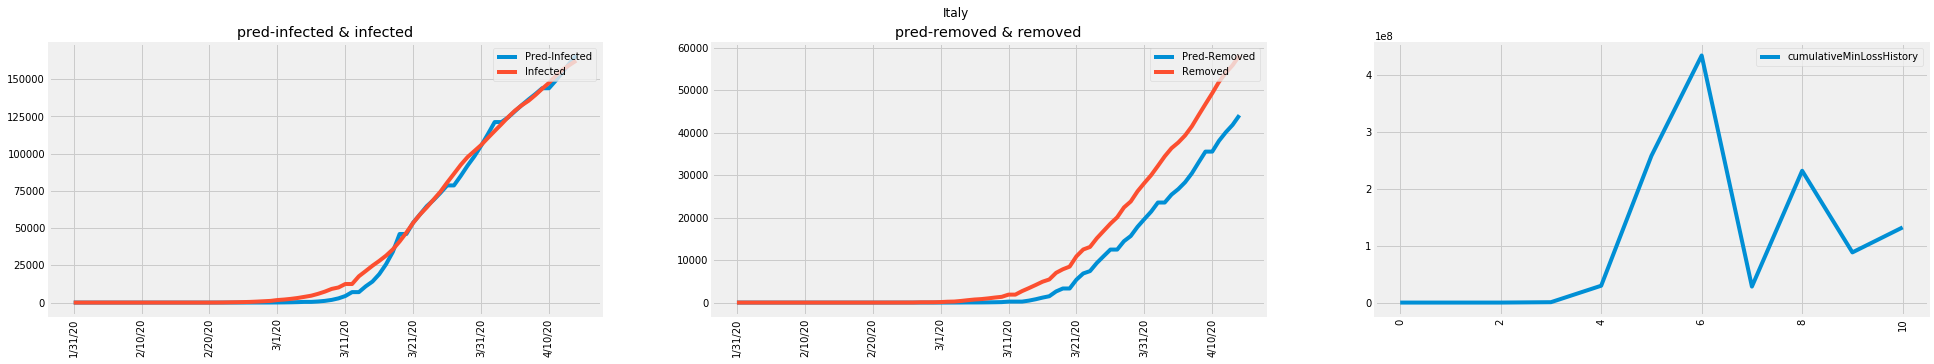

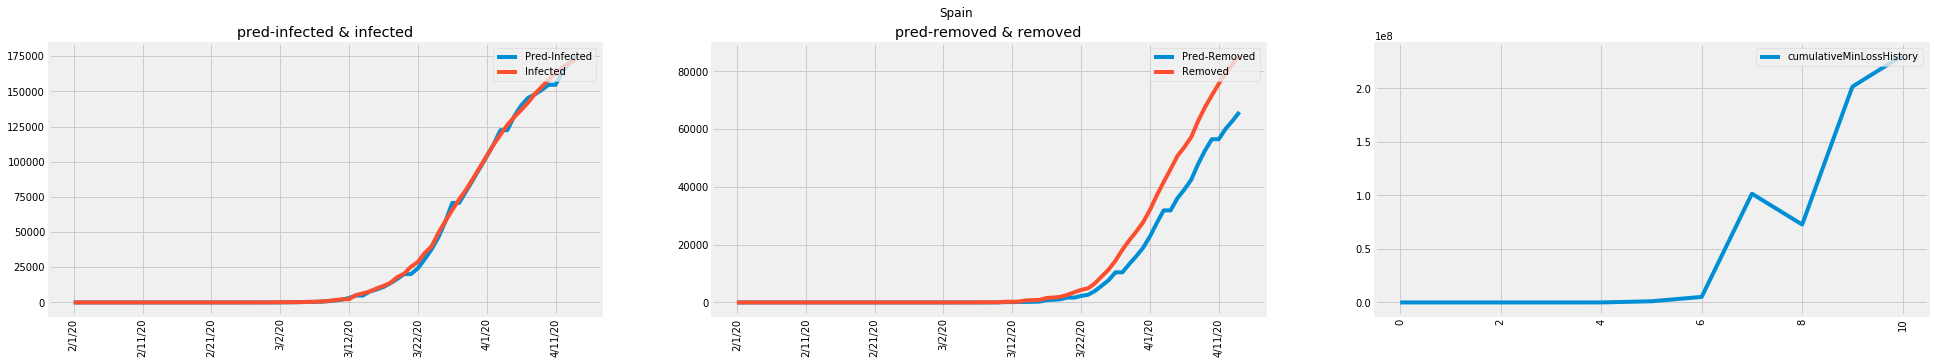

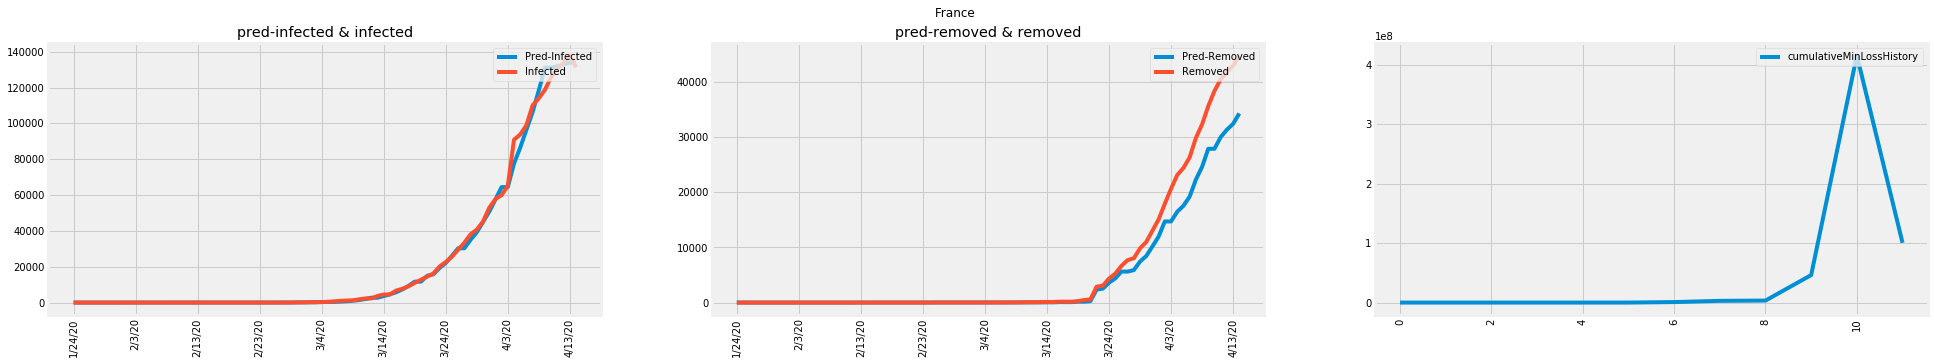

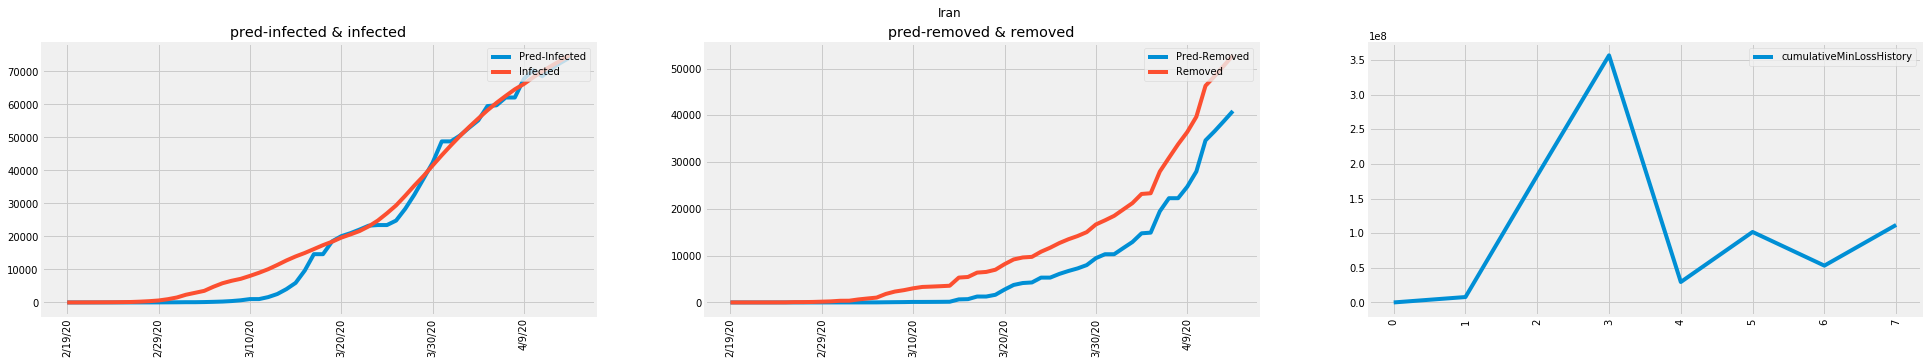

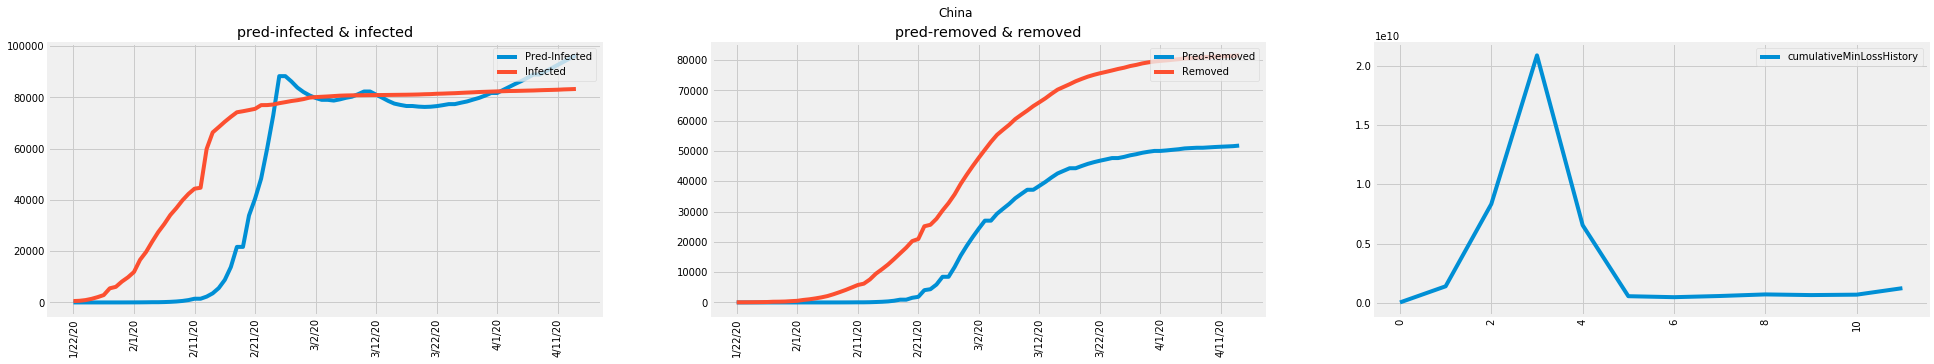

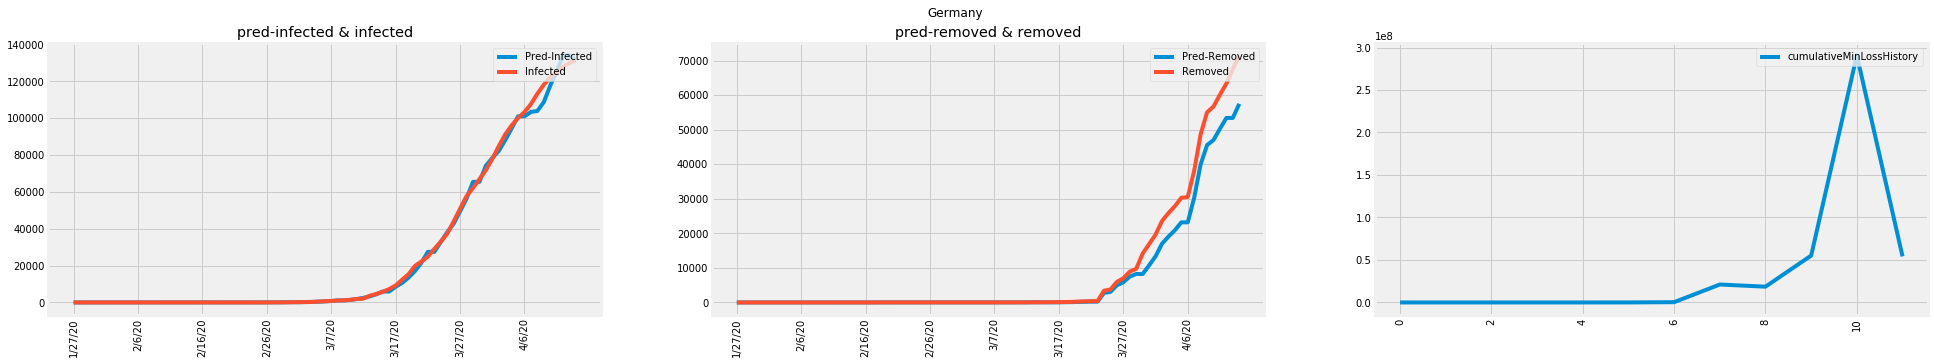

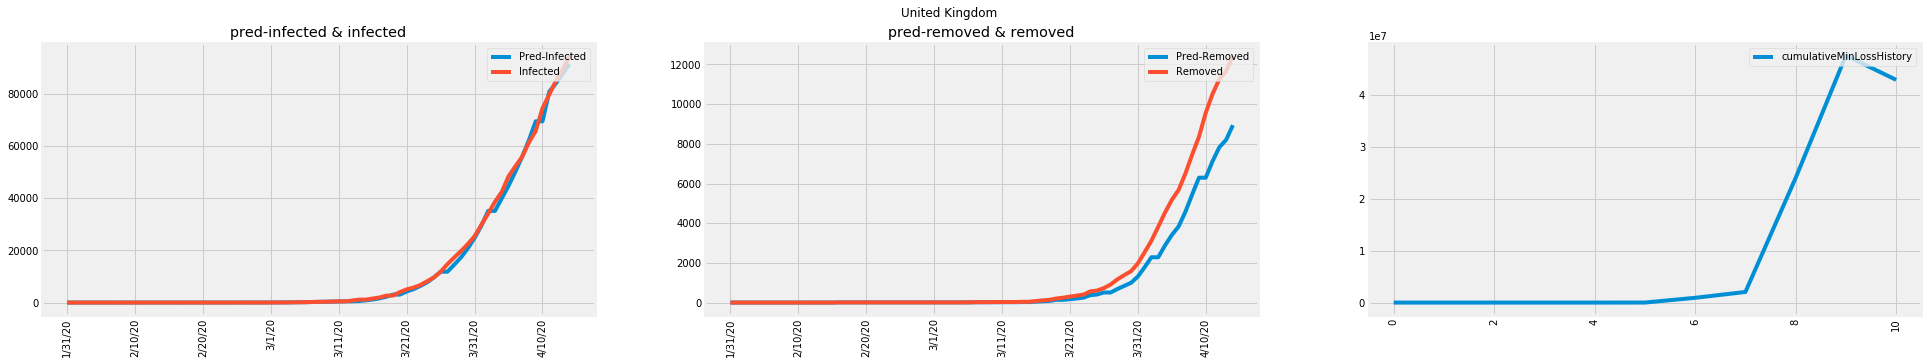

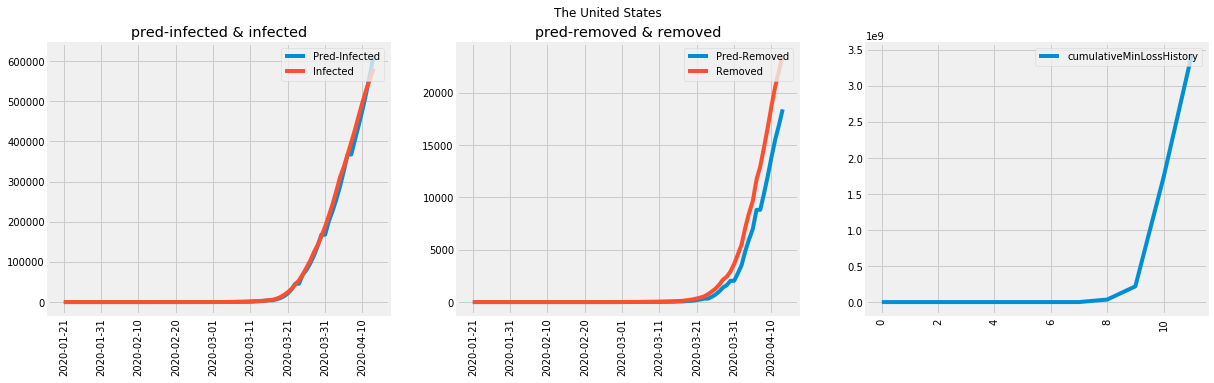

In [11]:
computeParamsWithStepSize(7)

,Country,Params
0,India,"[[0.651, 0.15100000000000002, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], [0.651, 0.35100000000000003, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017857142857142856, 0.016129032258064516]], [0.6010000000000001, 0.251, [0.012195121951219513, 0.0, 0.07964601769911504, 0.0, 0.014084507042253521, 0.0, 0.010309278350515464, 0.02459016393442623, 0.006060606060606061, 0.017676767676767676, 0.006012024048096192, 0.024253731343283583, 0.0076103500761035, 0.013755158184319119, 0.03156708004509583, 0.015197568389057751, 0.013671875, 0.009592326139088728, 0.01717967072297781, 0.024024024024024024]], [0.9510000000000001, 0.201, [0.00038955979742890534, 0.01654769630110318, 0.0036231884057971015, 0.03830054416073671, 0.011297307475051779, 0.01910074374577417, 0.02408921933085502, 0.022900763358778626, 0.028060620412029363, 0.016730038022813688, 0.012245288433942408, 0.01854270044398015]]]"
1,Pakistan,"[[0.30100000000000005, 0.901, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.05263157894736842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.451, 0.201, [0.028634361233480177, 0.001996007984031936, 0.0, -0.007731958762886598, 0.001142857142857143, 0.01440329218106996, 0.0037629350893697085, 0.0008326394671107411, 0.0029133284777858705, 0.0046822742474916385, 0.0012523481527864746, 0.0314502038439138, 0.0025799793601651187, 0.008970727101038715, 0.01569599339116068, 0.0026061057334326137, 0.0021291696238466998, 0.027241051631295535, 0.014338821030270845, 0.04312267657992565]], [0.251, 0.101, [0.02428157718868345, 0.033226837060702875, 0.010975853123129115, 0.05181644359464627, 0.012554585152838428, 0.04899777282850779]]]"
2,Italy,"[[0.751, 0.101, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.801, 0.9510000000000001, [0.03225806451612903, 0.012903225806451613, 0.013100436681222707, 0.009316770186335404, 0.008830022075055188, 0.0717557251908397, 0.00563063063063063, 0.0070921985815602835, 0.024793388429752067, 0.0412573673870334, 0.015187849720223821, 0.04661702816445452, 0.046397096941420427, 0.034081104400345126, 0.017338092809790925, 0.022508474576271188, 0.021696467509812474, 0.016553355010345848, 0.041486117798106244, 0.0]], [0.401, 0.15100000000000002, [0.03318050763340738, 0.02978138764294662, 0.027269478198713365, 0.0170443725004761, 0.043653571528575026, 0.020519069087364446, 0.013334467578316071, 0.04526111463660458, 0.02710609083837803, 0.009401348413033616, 0.02956227593384989, 0.02310918721264754, 0.021231185397510826, 0.017433929108187474, 0.02512111774374946, 0.014351667024946514, 0.023609431977904244, 0.018394585601935874, 0.016685658473058765, 0.019012165703476164]], [0.051000000000000004, 0.101, [0.015397329738750883, 0.010422806092378323, 0.012508770473869646, 0.015923472924933253, 0.018942491142000546, 0.01802598415328701, 0.017312995927549688, 0.017718409940172455, 0.013481450215204364, 0.01122144487073397, 0.01413642853626114]]]"
3,Spain,"[[0.30100000000000005, 0.201, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.751, 0.801, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006060606060606061, 0.0045045045045045045, 0.003861003861003861, 0.005, 0.066, 0.010401188707280832, 0.012115563839701771, 0.004129793510324484, 0.07465963987703118, 0.0004391743522178305, 0.016819571865443424]], [0.801, 0.251, [0.01205437291613234, 0.006638503319251659, 0.05864828055839292, 0.010280373831775701, 0.012971107276067472, 0.034002939735423815, 0.03424765508000315, 0.029442436040044494, 0.015340391621129327, 0.043023693117713424, 0.04871251136019388, 0.04094417332918008, 0.04739877356624416, 0.051505427732641496, 0.040506803145674695, 0.033926053936058936, 0.03364156667326918, 0.041404944390019016, 0.045125596751885065, 0.03875871441874512]], [0.101, 0.101, [0.034600367

<Figure size 432x288 with 0 Axes>

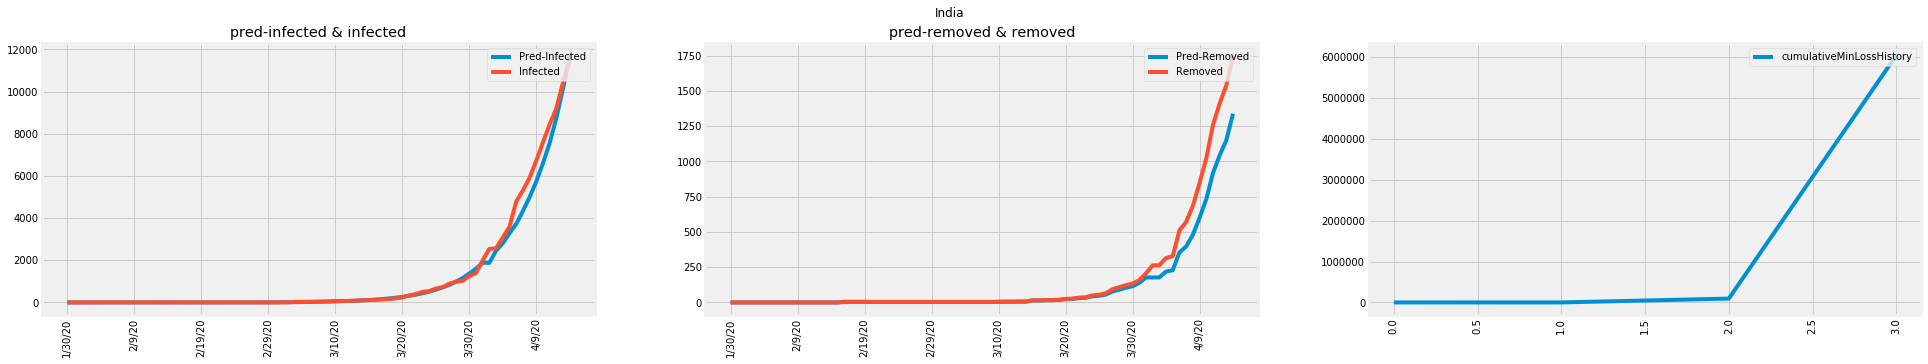

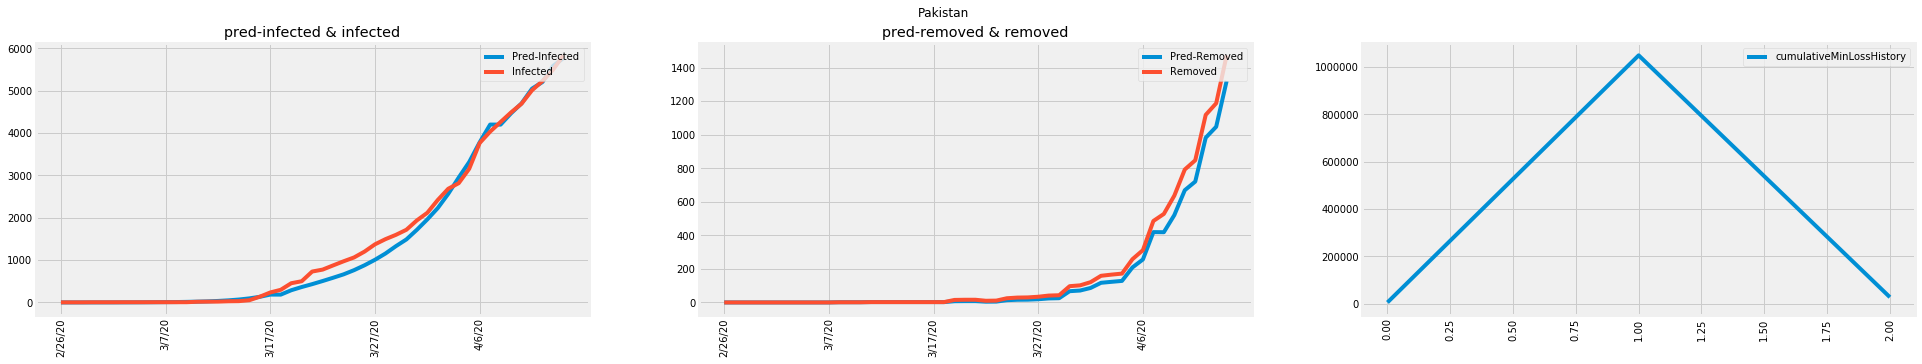

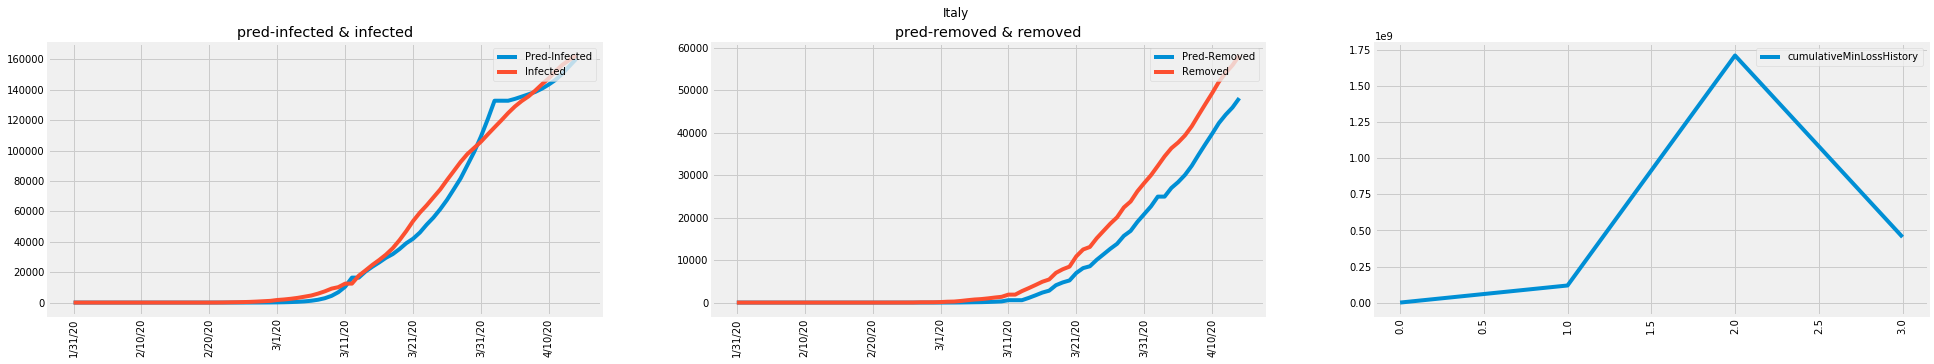

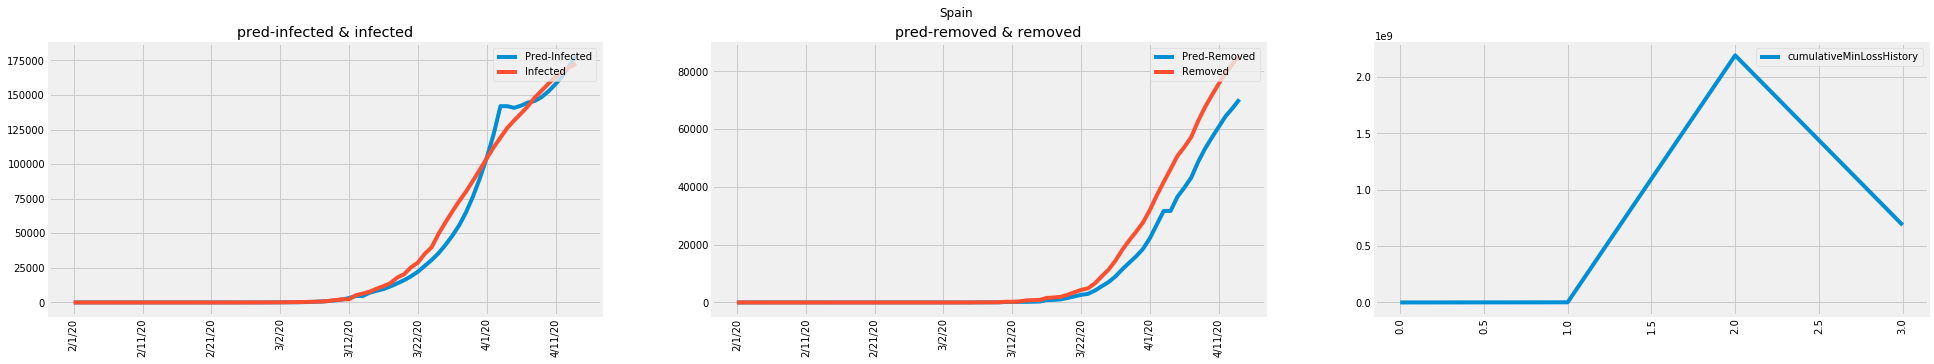

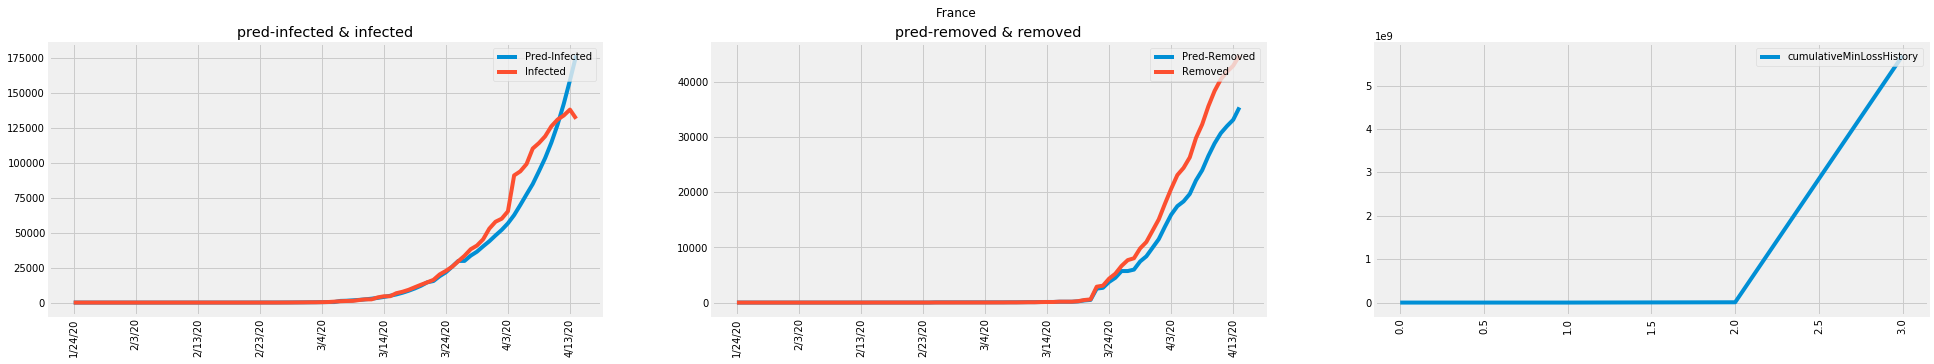

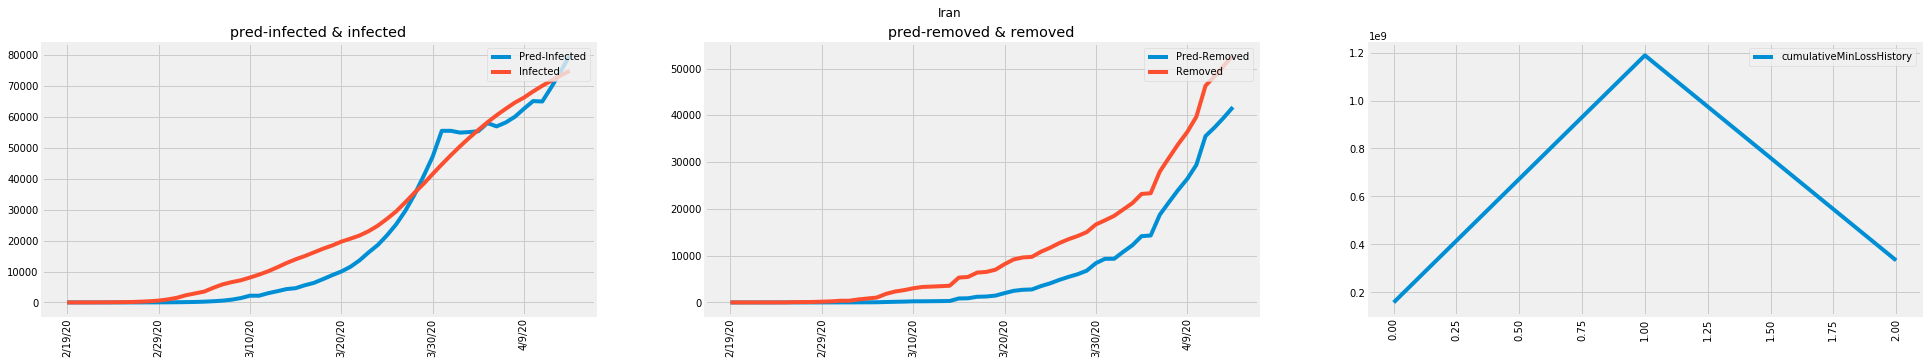

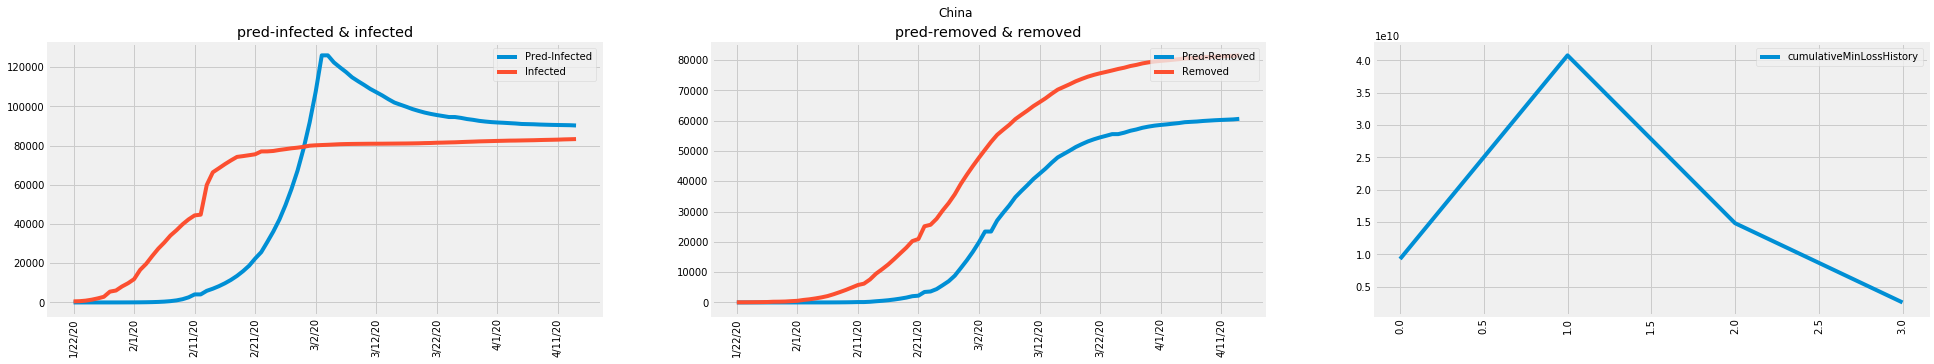

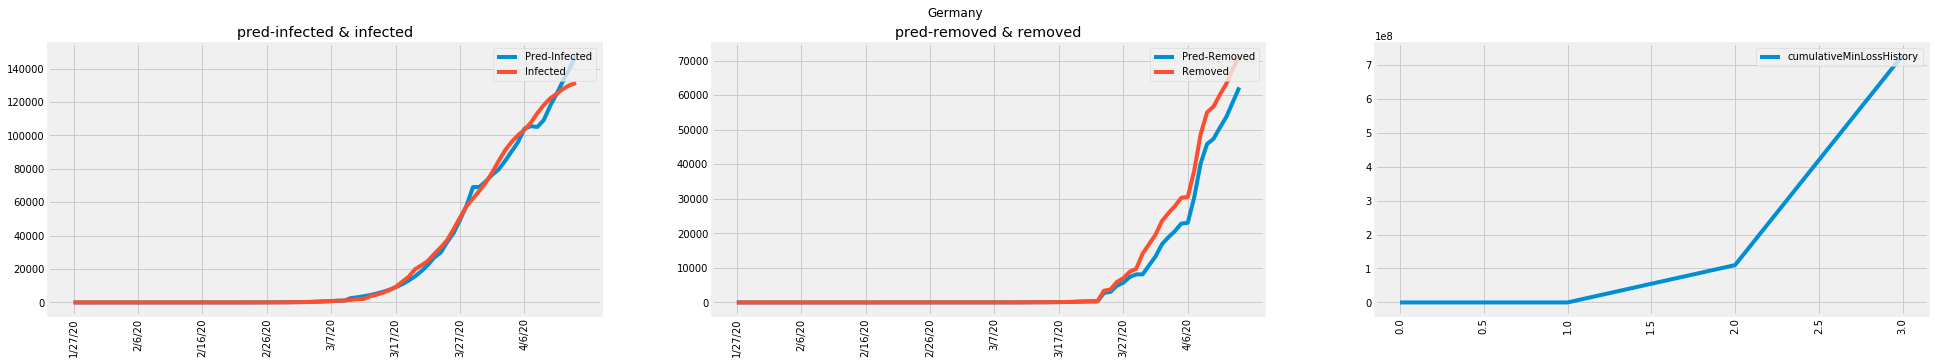

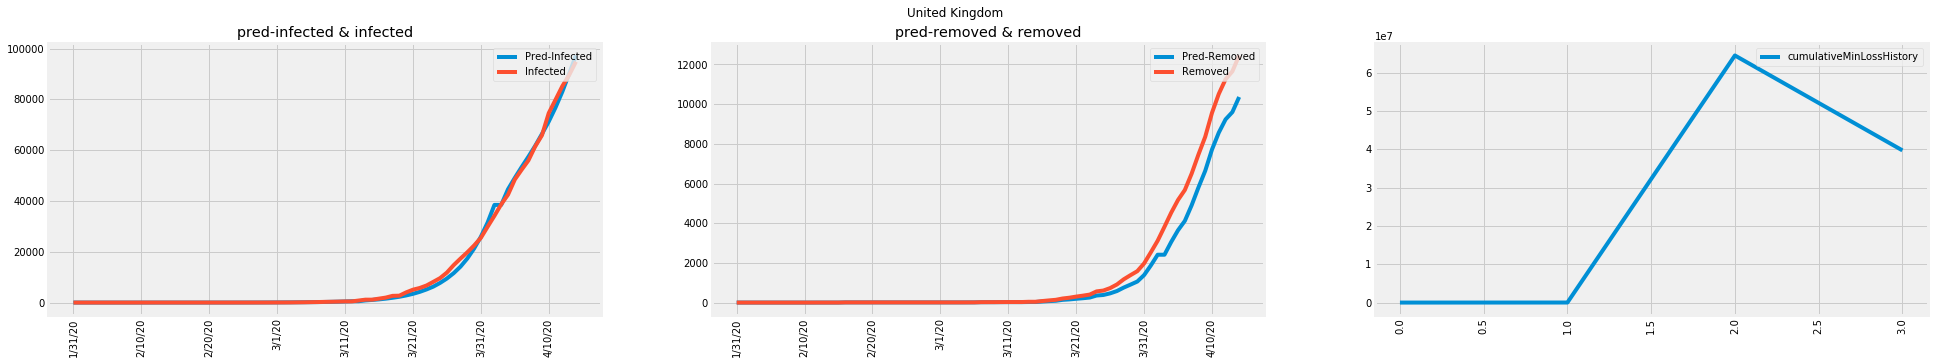

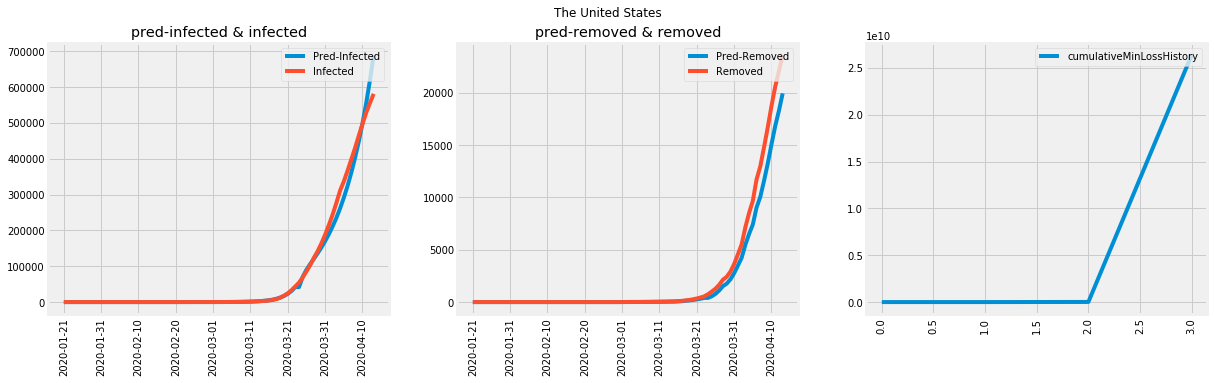

In [12]:
computeParamsWithStepSize(21)

,Country,Params
0,India,"[[0.9510000000000001, 0.15100000000000002, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.551, 0.201, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.30100000000000005, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017857142857142856, 0.016129032258064516]], [0.551, 0.30100000000000005, [0.012195121951219513, 0.0, 0.07964601769911504, 0.0, 0.014084507042253521, 0.0, 0.010309278350515464, 0.02459016393442623, 0.006060606060606061, 0.017676767676767676, 0.006012024048096192, 0.024253731343283583, 0.0076103500761035]], [0.7010000000000001, 0.251, [0.03156708004509583, 0.015197568389057751, 0.013671875, 0.009592326139088728, 0.01717967072297781, 0.024024024024024024, 0.022414471097129376, 0.00038955979742890534, 0.01654769630110318, 0.0036231884057971015, 0.03830054416073671, 0.011297307475051779, 0.01910074374577417]], [0.8510000000000001, 0.15100000000000002, [0.022900763358778626, 0.028060620412029363, 0.016730038022813688, 0.012245288433942408, 0.01854270044398015]]]"
1,Pakistan,"[[0.9510000000000001, 0.35100000000000003, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0]], [0.901, 0.651, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.028634361233480177, 0.001996007984031936, 0.0, -0.007731958762886598, 0.001142857142857143, 0.01440329218106996]], [0.051000000000000004, 0.551, [0.0008326394671107411, 0.0029133284777858705, 0.0046822742474916385, 0.0012523481527864746, 0.0314502038439138, 0.0025799793601651187, 0.008970727101038715, 0.01569599339116068, 0.0026061057334326137, 0.0021291696238466998, 0.027241051631295535, 0.014338821030270845, 0.04312267657992565]], [0.051000000000000004, 0.001, [0.02428157718868345, 0.033226837060702875, 0.010975853123129115, 0.05181644359464627, 0.012554585152838428, 0.04899777282850779]]]"
2,Italy,"[[0.9510000000000001, 0.15100000000000002, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.8510000000000001, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.03225806451612903, 0.012903225806451613, 0.013100436681222707, 0.009316770186335404, 0.008830022075055188, 0.0717557251908397]], [0.901, 0.35100000000000003, [0.0070921985815602835, 0.024793388429752067, 0.0412573673870334, 0.015187849720223821, 0.04661702816445452, 0.046397096941420427, 0.034081104400345126, 0.017338092809790925, 0.022508474576271188, 0.021696467509812474, 0.016553355010345848, 0.041486117798106244, 0.0]], [0.751, 0.201, [0.03318050763340738, 0.02978138764294662, 0.027269478198713365, 0.0170443725004761, 0.043653571528575026, 0.020519069087364446, 0.013334467578316071, 0.04526111463660458, 0.02710609083837803, 0.009401348413033616, 0.02956227593384989, 0.02310918721264754, 0.021231185397510826]], [0.35100000000000003, 0.051000000000000004, [0.02512111774374946, 0.014351667024946514, 0.023609431977904244, 0.018394585601935874, 0.016685658473058765, 0.019012165703476164, 0.018743688818046018, 0.015397329738750883, 0.010422806092378323, 0.012508770473869646, 0.015923472924933253, 0.018942491142000546, 0.01802598415328701]], [0.451, 0.051000000000000004, [0.017718409940172455, 0.013481450215204364, 0.01122144487073397, 0.01413642853626114]]]"
3,Spain,"[[0.651, 0.101, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.101, 0.901, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.551, 0.8510000000000001, [0.0, 0.0, 0.006060606060606061, 0.0045045045045045045, 0.003861003861003861, 0.005, 0.066, 0.010401188707280832, 0.012115563839701771, 0.004129793510324484, 0.07465963987703118, 0.0004391743522178305, 0.016819571865443424]], [0.751, 0.30100000000000005, [0.01205437291613234, 0.006638503319251659, 0.05864828055839292, 0.010280373831775701, 0.012971107276067472, 0.034002939735423815, 0.03424765508000315, 0.029442436040044494, 0.015340391621129327, 0.043023693117713424, 0.04871251136019388, 0.04094417332918008, 0.04739877356624416]], [0.7

<Figure size 432x288 with 0 Axes>

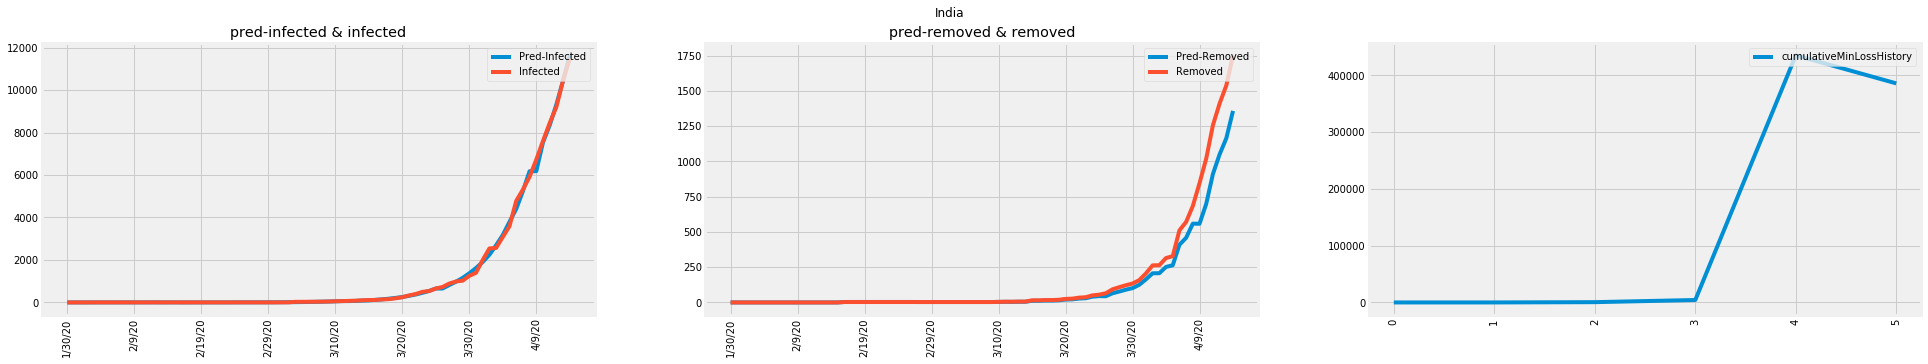

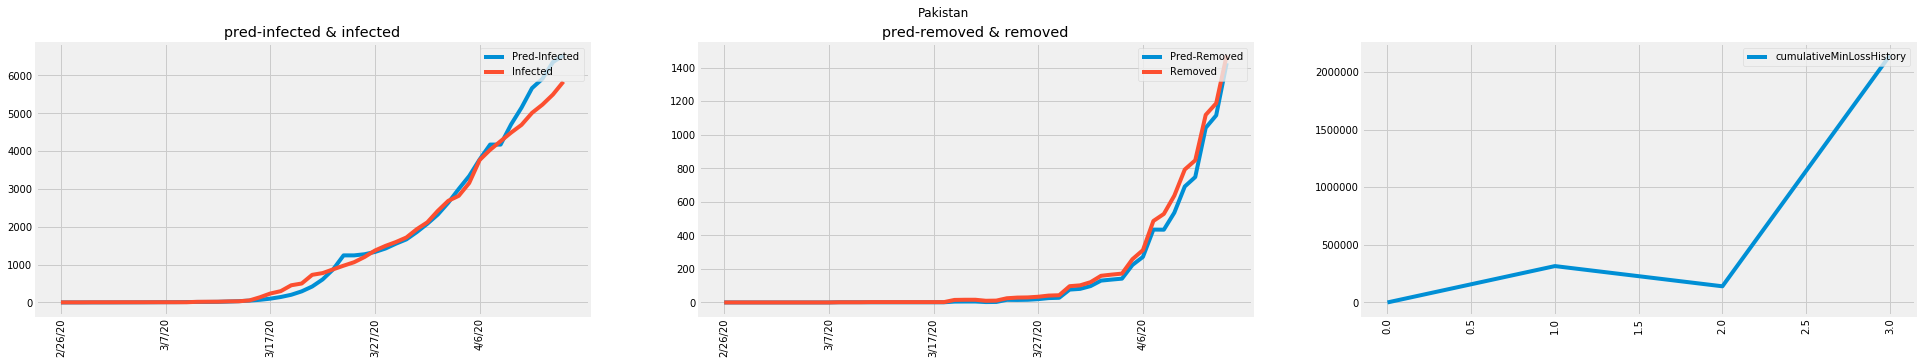

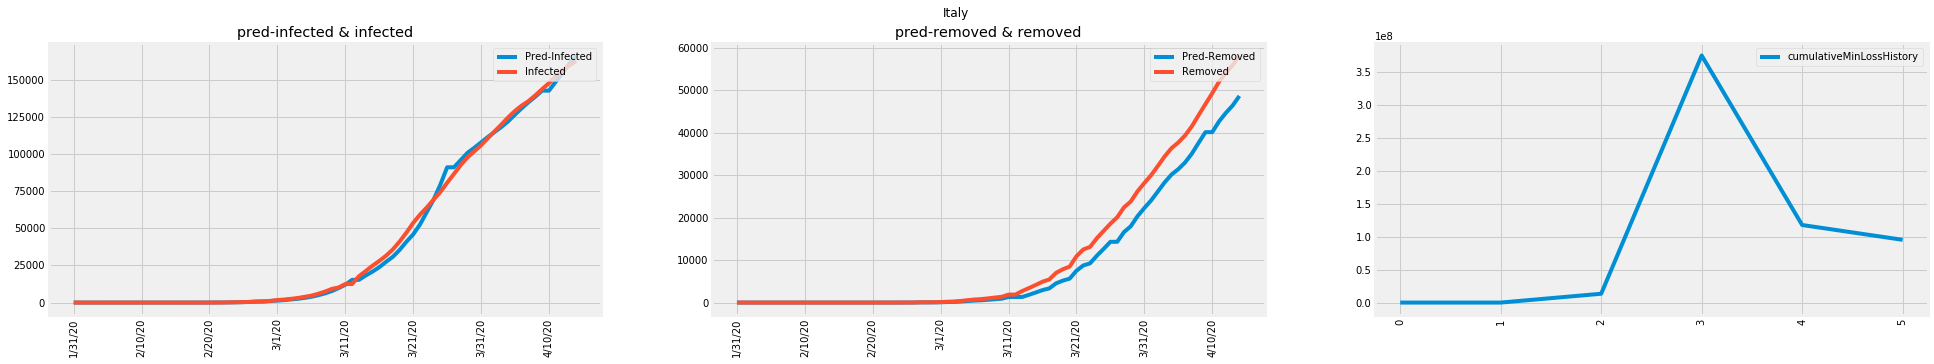

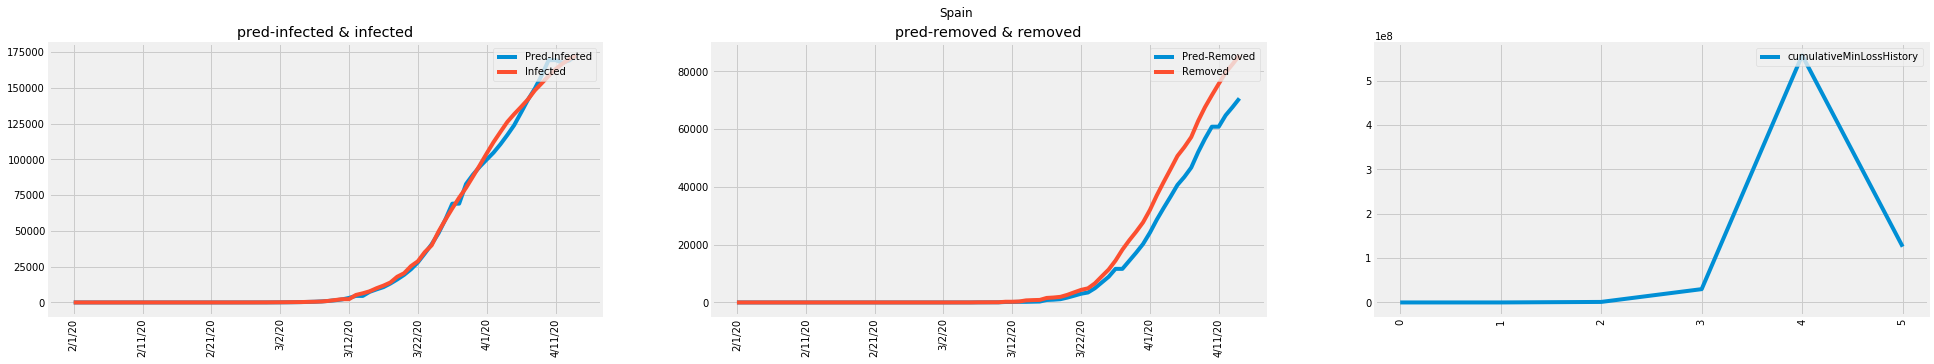

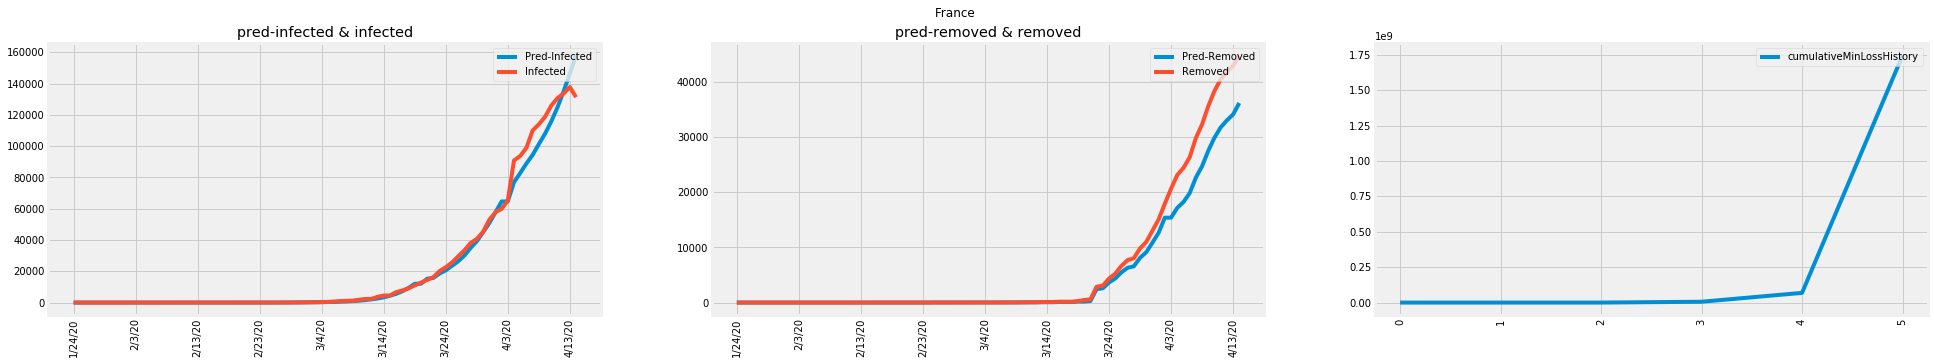

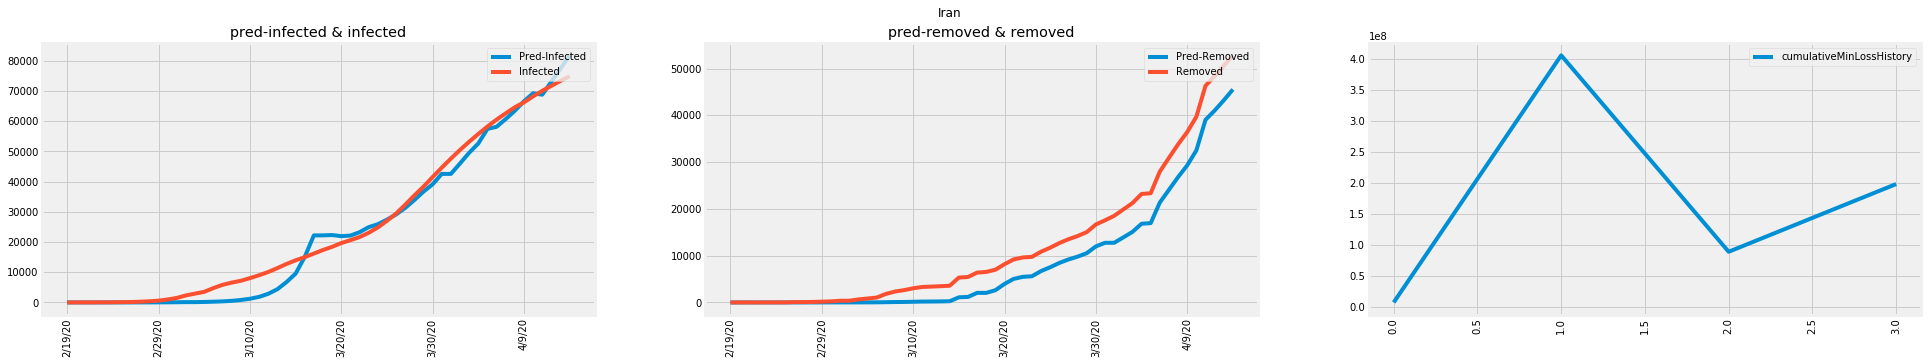

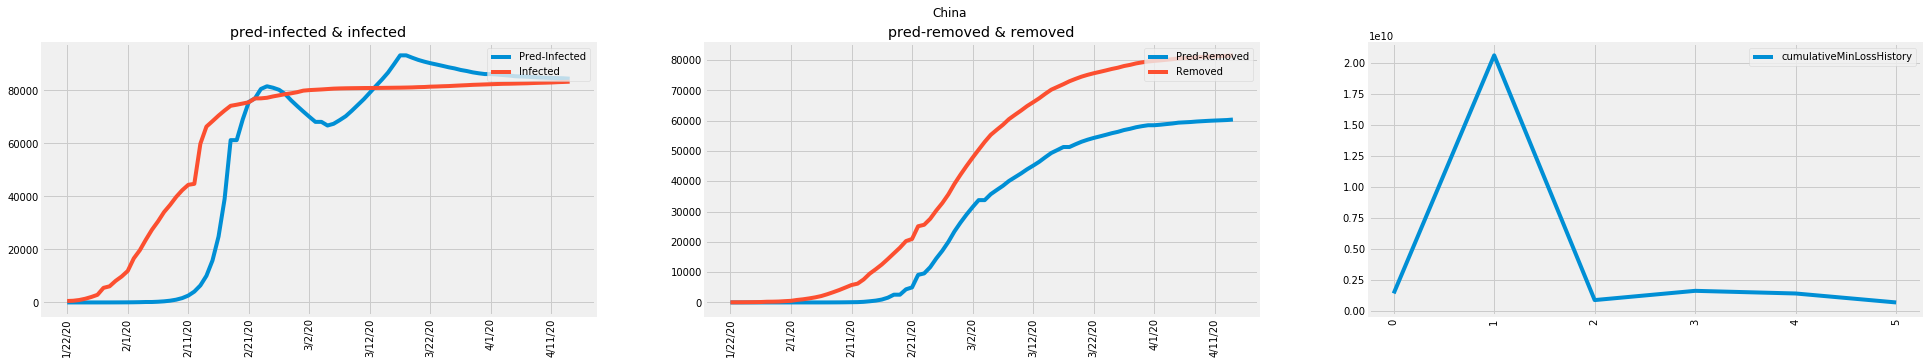

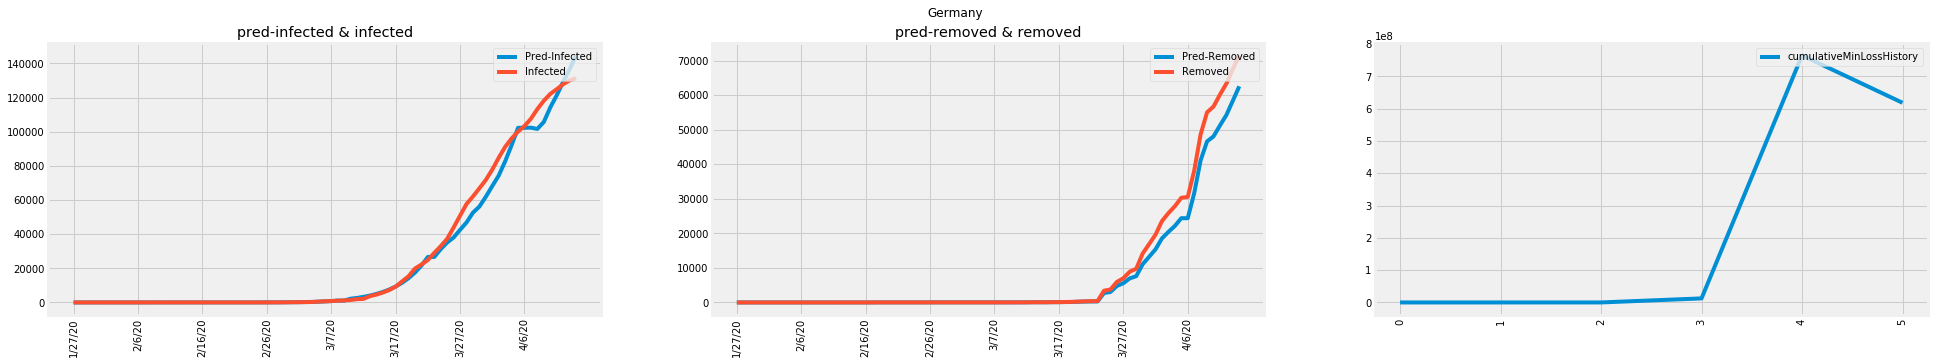

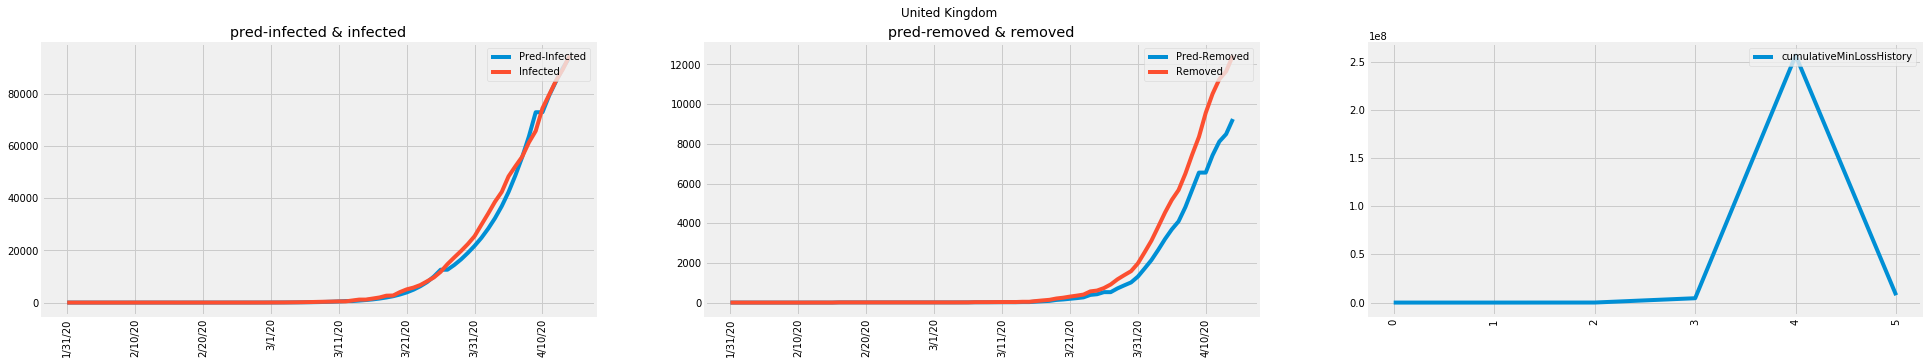

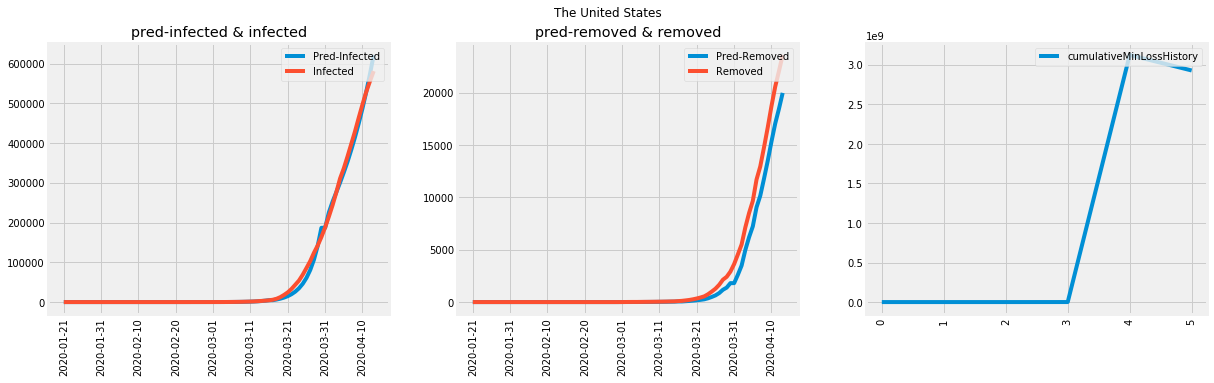

In [13]:
computeParamsWithStepSize(14)

In [ ]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
cumulativeLossDf['Accuracy_Score'] = min_max_scaler.fit_transform(cumulativeLossDf['Accuracy_Score'].values.reshape(-1, 1))
# Run the normalizer on the dataframe
# df_normalized = pd.DataFrame(x_scaled)
cumulativeLossDf[cumulativeLossDf['Accuracy_Score'] == 0] = 0.0001
cumulativeLossDf['Accuracy_Score'] = 1/cumulativeLossDf['Accuracy_Score']

display(cumulativeLossDf)
cumulativeLossDf_group_by_stepSize = cumulativeLossDf.groupby('Step_Size').max()
display(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize.max())